# Importing Packages

In [1]:
# Importing Packages
import os
import timeit
import numpy as np
import iris
import iris.quickplot as qplt
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("figure", figsize=(10, 10))
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"
from mpl_toolkits.basemap import Basemap

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, HMC, BarkerMH
from numpyro.distributions import constraints
import jax.numpy as jnp
from jax import random, vmap, jit
import jax.scipy.stats.gamma as jgamma

import gpflow 
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter
from gpflow.kernels import Matern32
from gpflow.models import SGPR
import tensorflow as tf
from tensorflow.keras.optimizers import Optimizer
from scipy.cluster.vq import kmeans2

# Importing Project Modules:
from src.netcdf_functions import aggregate_to_daily
from src.netcdf_functions import add_2d_latlon_aux_coords
from src.netcdf_functions import concatenate_cubes
from src.netcdf_functions import pcolormesh_basemapplot_cube
from src.netcdf_functions import pcolormesh_basemapplot_data
from src.model_fitting_functions import BernoulliGamma
from src.model_fitting_functions import train_sgpr
from src.model_fitting_functions import standardise
from src.model_fitting_functions import unstandardise
from src.model_fitting_functions import transform_y
from src.model_fitting_functions import untransform_y
from src.model_fitting_functions import get_inducing
from src.plotting_functions import histogram_plot
from src.plotting_functions import bernoulli_gamma_pdf_plot

2022-03-29 15:06:21.521036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [32]:
import os
import timeit
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import random, vmap, jit
import iris
import iris.coord_categorisation
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC, BarkerMH
import gpflow
from sklearn.metrics import r2_score
import skgstat as skg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("figure", figsize=(10, 10))
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"
from mpl_toolkits.basemap import Basemap
from src.model_fitting_functions import lima_model 
from src.model_fitting_functions import BernoulliGamma
from src.plotting_functions import histogram_plot
from src.plotting_functions import bernoulli_gamma_pdf_plot
from src.plotting_functions import lima_alpha_beta_relationship_scatter
from src.netcdf_functions import pcolormesh_basemapplot_cube
from src.netcdf_functions import pcolormesh_basemapplot_data

# Estimating PDF parameter values

From previous literature (Lima, 2021, https://doi.org/10.1016/j.jhydrol.2021.126095) it seems reasonable to assume a Bernoulli-Gamma distribution for daily snowfall. This has the form:

$P(Y_{jk}=y_{jk}) = B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})$

$B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk}) = \ p_{jk} \cdot \dfrac{{\beta_{jk}}^{\alpha_{jk}} y_{jk}^{\alpha_{jk}-1}e^{-\beta_{jk} y_{jk}}}{\Gamma(\alpha_{jk})} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p_{jk}) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

The Bernoulli part gives the probability of rainfall (p) or no rainfall (1-p) on a given day at the site \(j\) for month \(k\) and the Gamma part gives the probability of an intensity of rainfall ($y_{jk}$) on that day given rainfall occurs. The gamma distribution has shape parameter $\alpha$ and scale parameter $\beta$. Note: it makes sense to include a Bernoulli term because of the discontinuity expected for the probability of no rainfall. The shape/scale parameters $\alpha$ and $\beta$ are estimated at every rainfall gauge and for each month of the year. 

Bayesian inference is used to estimate the parameters $p,\alpha,\beta$ for every rainfall gauge and month. 

\begin{equation}
    P(\boldsymbol{p,\alpha,\beta}|\boldsymbol{y}) = P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot \dfrac{P(\boldsymbol{\boldsymbol{p,\alpha,\beta}})}{P(\boldsymbol{y})} \propto P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

\begin{equation}
    P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot P(\boldsymbol{\boldsymbol{p,\alpha,\beta}}) =
    (\prod_{jk} B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})) \cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

# Bayesian Inference

We are treating the parameters $[p,\alpha,\beta]$ as stochastic variables here with probability distributions to estimate (the posterior distribution). In addition to simply estimating the parameters that maximise our likelihood, this also allows us to estimate a credible interval and plot the uncertainty on our modelled PDF of snowfall.

$Posterior = \dfrac{Likelihood \cdot Prior}{Normalising Constant} $

$P(\boldsymbol{p,\alpha,\beta}|\boldsymbol{y}) = \dfrac{P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot P(\boldsymbol{\boldsymbol{p,\alpha,\beta}})}{P(\boldsymbol{y})} $

$P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta}) = \prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta)\cdot P(p,\alpha,\beta)$

$P(\boldsymbol{y}) = \iiint\limits_{\theta} P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta}) \,dp\,d\alpha\,d\beta$

Note we don't need the normalising constant to estimate the most likely values of the parameters $\theta=[p,\alpha,\beta]$ (MAP), but we do need it for normalising the distributions of the parameters and so for uncertainty estimates. Note also that MLE is just MAP but with uniform priors and that MAP is not much more difficult than MLE and can be done with a basic minimizer. The point of full Bayesian inference is we are actually getting a posterior probability, which is harder to do than to just maximise it. This gives us a distribution over the parameters with which to construct credibility intervals. 


# Multiple Sites, Multiple Months Example

Now in Lima, 2021 to deal with the impact of seasonality parameters are estimated for individual months (k).

For multiple sites (j) and multiple months (k) we have:

$P(\boldsymbol{Y}=\boldsymbol{y_i}) = B(1,\boldsymbol{p})\cdot G(\boldsymbol{y_i}|\boldsymbol{\alpha},\boldsymbol{\beta})$

Where:

$\boldsymbol{Y}=[Y_{00},Y_{01},Y_{1,0},...,Y_{jk}]$
,$\boldsymbol{y}=[y_{00},y_{01},y_{1,0},...,y_{jk}]$
,$\boldsymbol{p}=[p_{00},p_{01},p_{1,0},...,p_{jk}]$
,$\boldsymbol{\alpha}=[\alpha_{00},\alpha_{01},\alpha_{1,0},...,\alpha_{jk}]$
,$\boldsymbol{\beta}=[\beta_{00},\beta_{01},\beta_{1,0},...,\beta_{jk}]$

$P(Y_{jk}=y_{jk}) = B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})$

$B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk}) = \ p_{jk} \cdot \dfrac{{\beta_{jk}}^{\alpha_{jk}} y_{jk}^{\alpha_{jk}-1}e^{-\beta_{jk} y_{jk}}}{\Gamma(\alpha_{jk})} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p_{jk}) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

In Lima, 2021 it is noted that there exists a spatial correlation between $\alpha_{jk}$ and $\beta_{jk}$, which we want to preserve in the model and so we specify $\beta_{jk}$ as a log normally distributed linear function of $\alpha_{jk}$.

$\beta_{jk} \sim  LN(a_0+a_1 \cdot \alpha_{jk},\sigma^{2})$

The set of parameters $[a_0,a_1,\sigma]$ are hyper-parameters, in that they are not dependent on j or k.


$Likelihood = P(\boldsymbol{Y}|\boldsymbol{p},\boldsymbol{\alpha},\beta) = \prod_\limits{jk}P(Y_{jk}|p_{jk},\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2) = \prod_\limits{ijk} B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2)$

$Log Likehood = Log(\prod_\limits{ijk} B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2)) = \sum_\limits{ijk} Log(B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2))$

In [2]:
jdata = np.load('/data/notebooks/jupyterlab-biascorrlab/data/AP_Daily_Snowfall.npy')

In [3]:
jdata.shape

(1000, 2, 100)

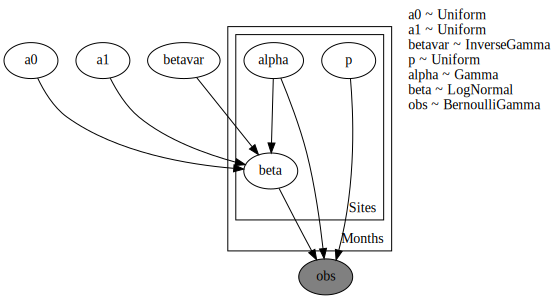

In [5]:
numpyro.render_model(
    lima_model, model_args=(jdata,), render_distributions=True
)

In [6]:
mcmc_samples_obj = np.load('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_MCMC_samples.npy',allow_pickle=True)
mcmc_samples_dict = dict(zip(mcmc_samples_obj[:,0], mcmc_samples_obj[:,1]))

In [7]:
parameters = ['p','alpha','beta']
hyper_parameters = ['a0','a1','betavar']
df_params = pd.DataFrame(np.array([mcmc_samples_dict[param].mean(axis=0)[0] for param in parameters]).T,columns=parameters)
df_hparams = pd.DataFrame(np.array([mcmc_samples_dict[hparam] for hparam in hyper_parameters]).T,columns=hyper_parameters)

In [8]:
pd.concat([df_params.describe(),df_hparams.describe()], axis=1)

,p,alpha,beta,a0,a1,betavar
count,100.000000,100.000000,100.000000,2000.000000,2000.000000,2000.000000
mean,0.591463,0.778163,0.368989,-5.143295,5.120271,0.314214
std,0.138915,0.089819,0.192804,0.184162,0.248441,0.019969
min,0.317252,0.575058,0.082682,-5.728860,4.317232,0.245376
25%,0.477790,0.728023,0.237516,-5.268302,4.946620,0.300840
50%,0.580885,0.773918,0.317101,-5.144054,5.119789,0.313546
75%,0.715041,0.833426,0.485100,-5.016828,5.287536,0.326623
max,0.857306,0.987847,0.947104,-4.526018,5.909652,0.402719


Note: The above table examines 1 sample at 100 sitesfor January for parameters p, alpha and beta. While, it examines all 2000 samples for the hyper-parameters a0, a1 and betavar. 

In [11]:
site_index_min_alpha = np.argmin(mcmc_samples_dict['alpha'].mean(axis=(0,1)))
site_index_max_alpha = np.argmax(mcmc_samples_dict['alpha'].mean(axis=(0,1)))
months = [0,1]
sites = [site_index_min_alpha,site_index_max_alpha]
bounds = [0.1,10]

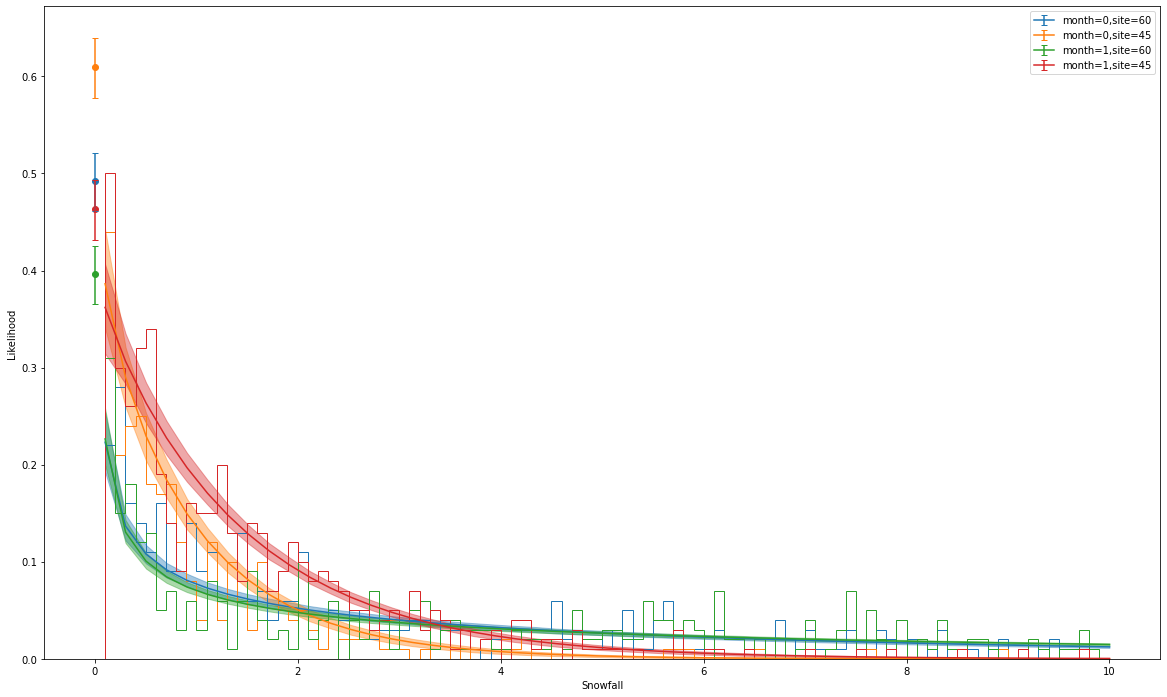

In [12]:
figure = plt.figure(figsize=(20,12))
histogram_plot(jdata,months,sites,bounds,0.1)
plt.gca().set_prop_cycle(None)
bernoulli_gamma_pdf_plot(mcmc_samples_dict,months,sites,bounds)
plt.xlabel("Snowfall")
plt.ylabel("Likelihood")
plt.legend()

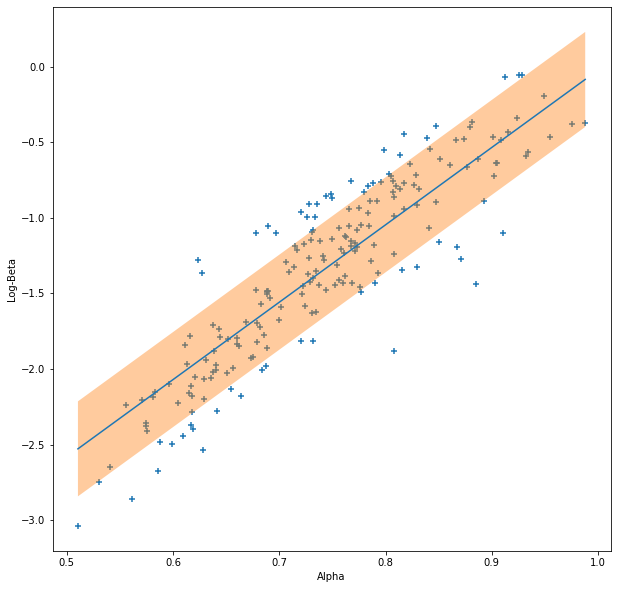

In [13]:
figure = plt.figure(figsize=(10,10))
lima_alpha_beta_relationship_scatter(mcmc_samples_dict)

# Fitting a GP

In [15]:
df = pd.read_csv('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_GP_Model_Alpha_df.csv',index_col=0)
df_stand = pd.read_csv('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_GP_Model_Alpha_df_stand.csv',index_col=0)
df_test = pd.read_csv('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_GP_Model_Alpha_df_test.csv',index_col=0)
df_train = pd.read_csv('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_GP_Model_Alpha_df_train.csv',index_col=0)
df_test_stand = pd.read_csv('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_GP_Model_Alpha_df_test_stand.csv',index_col=0)
df_train_stand = pd.read_csv('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_GP_Model_Alpha_df_train_stand.csv',index_col=0)

In [16]:
display(df.describe(),df_train.describe(),df_train_stand.describe())

,Grid_Latitude,Grid_Longitude,Alpha,Predictions
count,1050.000000,1050.000000,1050.000000,1050.000000
mean,2.420000,161.959999,0.766604,0.765218
std,3.810209,4.445900,0.090139,0.078096
min,-3.959999,154.479996,0.513574,0.542585
25%,-0.879999,158.000000,0.698102,0.710946
50%,2.420001,161.959991,0.767772,0.766585
75%,5.720001,165.919998,0.833280,0.820099
max,8.800001,169.440002,1.160097,1.058562


,Grid_Latitude,Grid_Longitude,Alpha,Predictions
count,525.000000,525.000000,525.000000,525.000000
mean,2.355048,161.916418,0.766675,0.766686
std,3.884349,4.468360,0.090633,0.088278
min,-3.959999,154.479996,0.528618,0.542585
25%,-1.320000,158.000000,0.698315,0.701144
50%,2.200001,161.959991,0.769447,0.769082
75%,5.720001,165.919998,0.832115,0.831476
max,8.800001,169.440002,1.075332,1.058562


,Grid_Latitude,Grid_Longitude,Alpha,Predictions
count,5.250000e+02,5.250000e+02,5.250000e+02,525.000000
mean,6.767074e-18,-2.382010e-15,-4.161750e-16,0.000116
std,1.000954e+00,1.000954e+00,1.000954e+00,0.974945
min,-1.627318e+00,-1.665827e+00,-2.629096e+00,-2.474842
25%,-9.470191e-01,-8.773137e-01,-7.549703e-01,-0.723729
50%,-3.995396e-02,9.760857e-03,3.061358e-02,0.026587
75%,8.671112e-01,8.968388e-01,7.227142e-01,0.715663
max,1.660793e+00,1.685352e+00,3.408806e+00,3.223597


Text(0.5, 1.0, 'Distribution of Standardised Alpha')

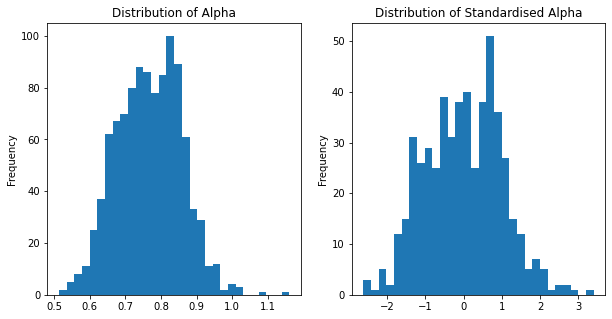

In [48]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
df['Alpha'].plot.hist(bins=30,ax=axs[0])
axs[0].set_title('Distribution of Alpha')
df_train_stand['Alpha'].plot.hist(bins=30,ax=axs[1])
axs[1].set_title('Distribution of Standardised Alpha')

In [17]:
model_summary_obj = np.load('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_GP_Model.npy',allow_pickle=True)
model_summary_dict = dict(zip(model_summary_obj[:,0], model_summary_obj[:,1]))

In [18]:
model_summary_dict

{'.kernel.variance': array(0.78761679),
 '.kernel.lengthscales': array([0.20341156, 0.06095216]),
 '.likelihood.variance': array(0.02413819)}

In [19]:
print('Training Data R2 Score = ',r2_score(df_train['Alpha'],df_train['Predictions'])) # true,pred
print('Test Data R2 Score = ',r2_score(df_test['Alpha'],df_test['Predictions'])) # true,pred

Training Data R2 Score =  0.9978544364511517
Test Data R2 Score =  0.6281090064611942


In [20]:
kern = gpflow.kernels.Matern32(lengthscales=model_summary_dict['.kernel.lengthscales'],variance=model_summary_dict['.kernel.variance'])

2022-04-06 12:04:46.532254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-06 12:04:46.532304: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Text(0.5, 1.0, 'Longitude Covariance Matrix')

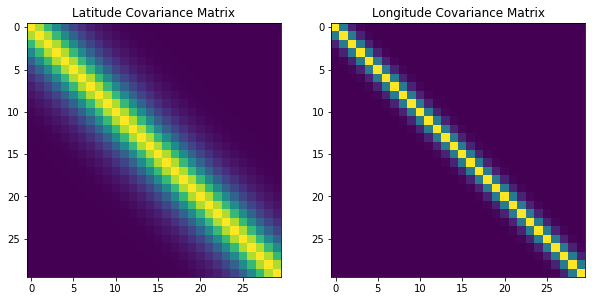

In [21]:
xs = np.linspace(-1, 1, 30).reshape(-1, 1)
zeros = np.zeros(xs.shape)
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(kern(np.hstack((xs,zeros))))
axs[0].set_title('Latitude Covariance Matrix')
axs[1].imshow(kern(np.hstack((zeros,xs))))
axs[1].set_title('Longitude Covariance Matrix')

Text(0.5, 1.0, 'Longitude MVN Example')

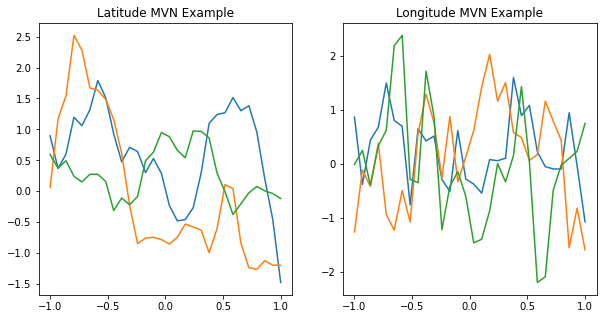

In [22]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(xs, np.random.multivariate_normal(np.zeros(len(xs)), kern(np.hstack((xs,zeros))), 3).T)
axs[0].set_title('Latitude MVN Example')
axs[1].plot(xs, np.random.multivariate_normal(np.zeros(len(xs)), kern(np.hstack((zeros,xs))), 3).T)
axs[1].set_title('Longitude MVN Example')

Text(0.5, 1.0, '2D Plot of Example MVN Distribution')

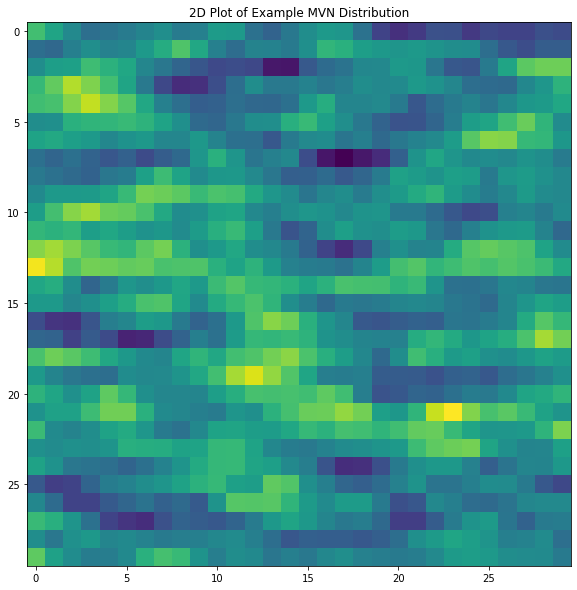

In [23]:
xs_m, ys_m = np.meshgrid(xs, xs)
xs_ys_m = np.vstack((xs_m.flatten(), ys_m.flatten())).T
MVN_values = np.random.multivariate_normal(np.zeros(xs_ys_m.shape[0]), kern(xs_ys_m)).reshape(xs.shape[0],xs.shape[0])
plt.imshow(MVN_values)
plt.title('2D Plot of Example MVN Distribution')

In [24]:
data_directory = '/data/climatedata/'
metum_cube = iris.load(f'{data_directory}metum_cube_lres.nc')[0]
metum_cube = metum_cube[:,40:70,5:40] # (time,grid_lat,grid_lon) #[:,40:70,5:40] selects Antarctic Peninsula
metum_cube = metum_cube.collapsed('time',iris.analysis.MEAN)
combine_lat_lon_size = metum_cube.shape[0]*metum_cube.shape[1]

/data/conda/bc/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_year'.
  warnings.warn(msg.format(self.name()))
/data/conda/bc/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/data/conda/bc/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_reference_time'.
  warnings.warn(msg.format(self.name()))
/data/conda/bc/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


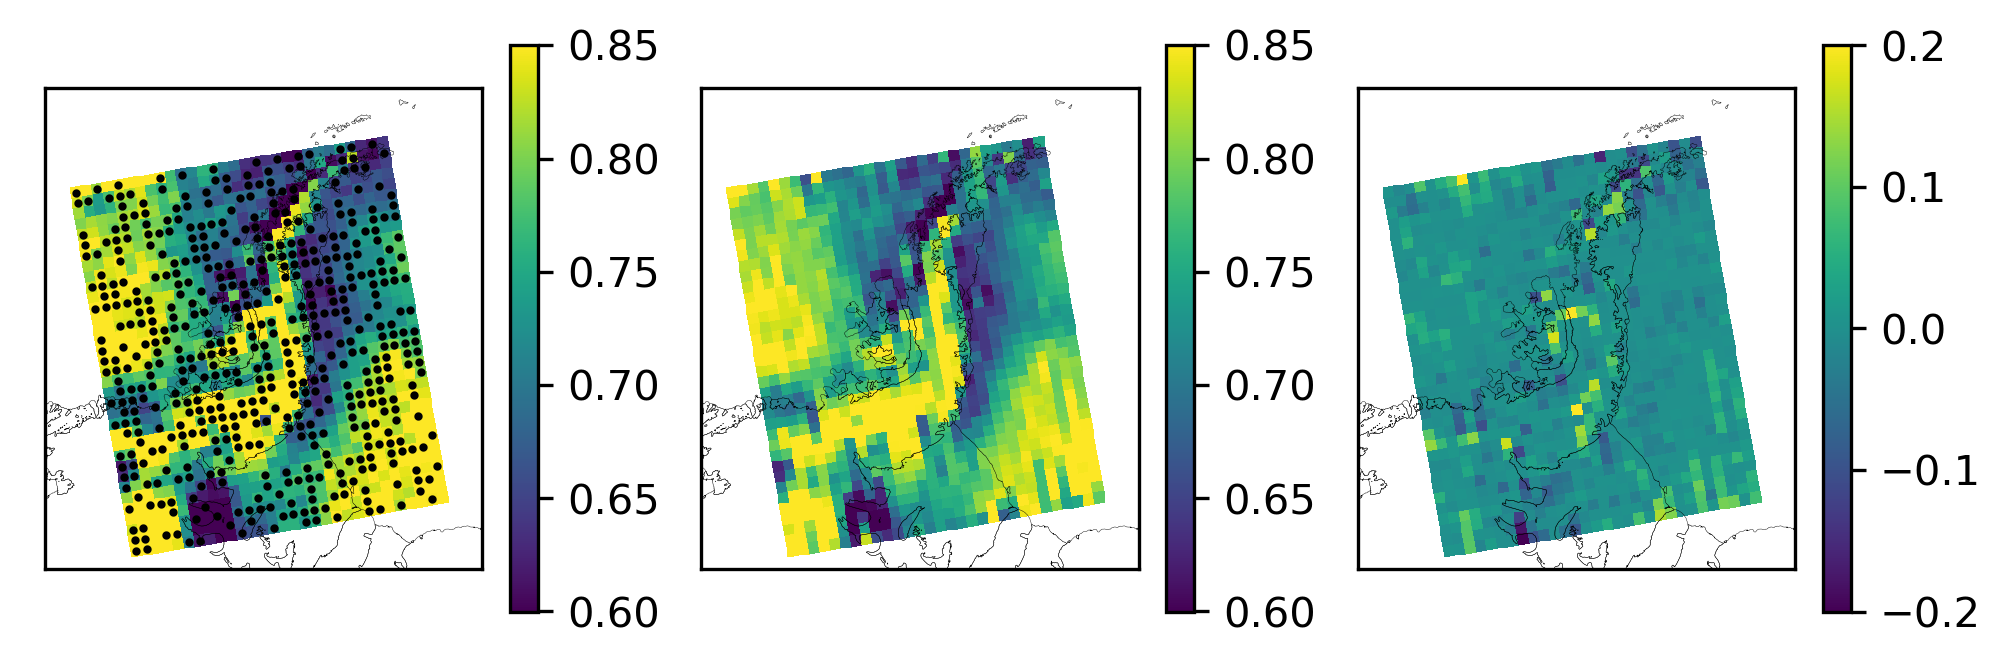

In [27]:
fig, ax = plt.subplots(1, 3,dpi= 300,figsize=(8,2.5))
antarctica_peninsula_map = Basemap(width=2000000,height=2200000,projection='laea',lat_ts=-55,lat_0=-71,lon_0=-67,resolution='l')

# Estimated Alphas from MCMC
plt.subplot(1,3,1)
plt.title('Estimated Alphas from MCMC',fontsize=6,color='w')
metum_cube.data = df['Alpha'].to_numpy().reshape(metum_cube.shape)
pcolormesh_basemapplot_cube(metum_cube,antarctica_peninsula_map,vmin=0.6,vmax=0.85)
lons,lats = metum_cube.coord('longitude').points.reshape(combine_lat_lon_size)[df_train.index.to_numpy()],metum_cube.coord('latitude').points.reshape(combine_lat_lon_size)[df_train.index.to_numpy()]
x, y = antarctica_peninsula_map(lons,lats)
plt.plot(x, y, 'ok', markersize=1)
plt.colorbar()

# Estimated Alphas from MCMC sample and GP interpolation
plt.subplot(1,3,2)
plt.title('Estimated Alphas from MCMC sample and GP interpolation',fontsize=6,color='w')
metum_cube.data = df['Predictions'].to_numpy().reshape(metum_cube.shape)
pcolormesh_basemapplot_cube(metum_cube,antarctica_peninsula_map,vmin=0.6,vmax=0.85)
plt.colorbar()

# Difference
plt.subplot(1,3,3)
plt.title('Difference between estimates',fontsize=6,color='w')
metum_cube.data = df['Alpha'].to_numpy().reshape(metum_cube.shape)-df['Predictions'].to_numpy().reshape(metum_cube.shape)
pcolormesh_basemapplot_cube(metum_cube,antarctica_peninsula_map,vmin=-0.2,vmax=0.2)
plt.colorbar()

plt.show()

In [29]:
coords = np.dstack([df['Grid_Latitude'].to_numpy(),df['Grid_Longitude'].to_numpy()]).reshape(1050,2)
coords_test = np.dstack([df_test['Grid_Latitude'].to_numpy(),df_test['Grid_Longitude'].to_numpy()]).reshape(-1,2)
coords_stand = np.dstack([df_stand['Grid_Latitude'].to_numpy(),df_stand['Grid_Longitude'].to_numpy()]).reshape(-1,2)
alpha_values = df['Alpha'].to_numpy()#.reshape(-1,1)
prediction_values = df_test['Predictions'].to_numpy()#.reshape(-1,1)
alpha_values_stand = df_stand['Alpha'].to_numpy()#.reshape(-1,1)

In [30]:
V_empirical = skg.Variogram(coords,alpha_values,n_lags=40)
V_prediction = skg.Variogram(coords_test,prediction_values,n_lags=40)
V_stand = skg.Variogram(coords_stand,alpha_values_stand,n_lags=40)

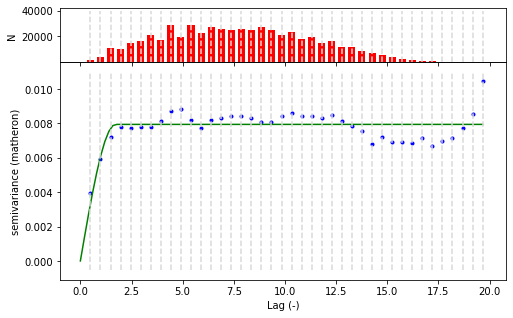

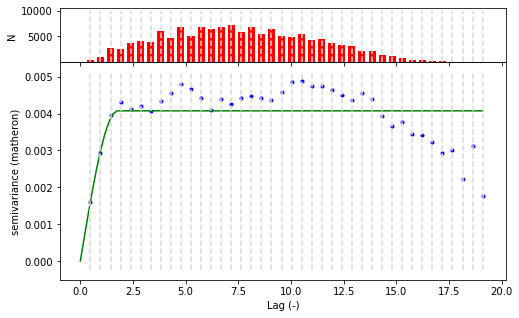

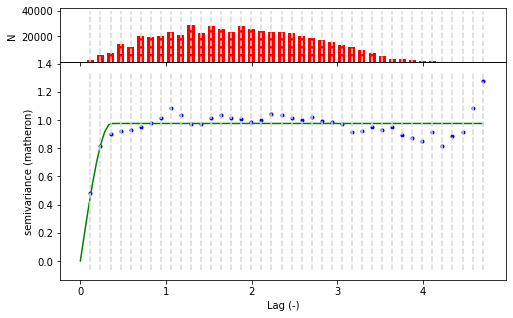

In [31]:
V_empirical.plot()
V_prediction.plot()
V_stand.plot()
plt.show()

In [276]:
coords_stand = np.dstack([df_stand['Grid_Latitude'].to_numpy(),df_stand['Grid_Longitude'].to_numpy()]).reshape(1050,2)
MVN_stand_values = np.random.multivariate_normal(np.zeros(xs_ys_m.shape[0]), kern(xs_ys_m)).reshape(xs.shape[0],xs.shape[0])

In [329]:
MVN_values = np.array([])
MVN_coords = np.array([]).reshape(0,2)
xs = np.linspace(-1, 1, 30).reshape(-1, 1)
xs_m, ys_m = np.meshgrid(xs, xs)
xs_ys_m = np.vstack((xs_m.flatten(), ys_m.flatten())).T
for i in np.arange(0,10,1):
    values = np.random.multivariate_normal(np.zeros(xs_ys_m.shape[0]), kern(xs_ys_m))
    MVN_values = np.append(MVN_values,values)
    MVN_coords = np.vstack((MVN_coords,xs_ys_m))

In [330]:
V_GP = skg.Variogram(MVN_coords,MVN_values.reshape(-1),n_lags=40)

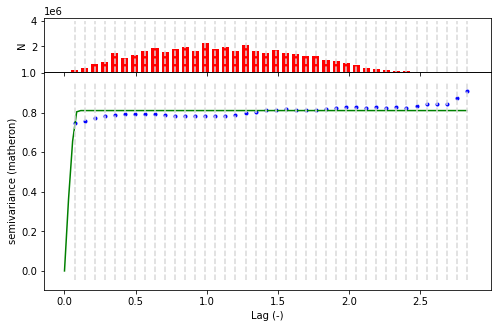

In [331]:
V_GP.plot()
plt.show()

In [33]:
xs = np.linspace(0,2,100)
xs_semivariogram = np.dstack((xs,xs)).reshape(-1,2)

In [34]:
lat_scale = StandardScaler().fit(df_train[['Grid_Latitude']])
lon_scale = StandardScaler().fit(df_train[['Grid_Longitude']])
xs_semivariogram_unscaled = np.dstack((xs*lat_scale.scale_,xs*lon_scale.scale_)).reshape(-1,2)

In [35]:
gp_samples_obj = np.load('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_GP_samples.npy',allow_pickle=True)
gp_samples_dict = dict(zip(gp_samples_obj[:,0], gp_samples_obj[:,1]))

In [36]:
distances = np.sqrt(xs_semivariogram_unscaled[:,0]**2+xs_semivariogram_unscaled[:,1]**2)

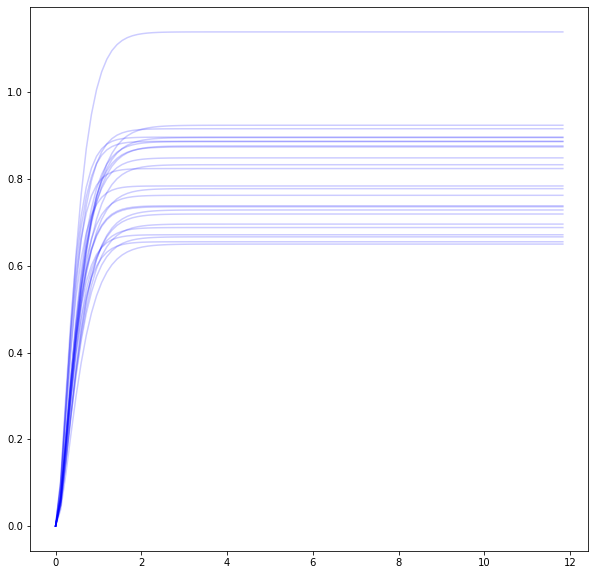

In [37]:
for i in np.arange(0,499,20):
    kern_ = gpflow.kernels.Matern32(lengthscales=gp_samples_dict['kernel_lengthscales'][i],variance=gp_samples_dict['kernel_variance'][i])
    plt.plot(distances,(-kern_(xs_semivariogram)[0]+kern_(xs_semivariogram)[0][0]),color='b',alpha=0.2)

Text(0.5, 1.0, 'Semivariogram for Alpha values')

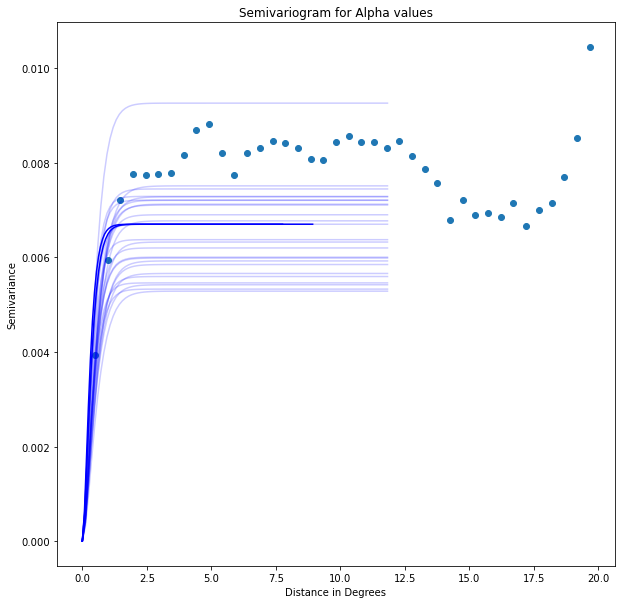

In [38]:
for i in np.arange(0,499,20):
    kern_ = gpflow.kernels.Matern32(lengthscales=gp_samples_dict['kernel_lengthscales'][i],variance=gp_samples_dict['kernel_variance'][i])
    plt.plot(distances,df['Alpha'].var()*(-kern_(xs_semivariogram)[0]+kern_(xs_semivariogram)[0][0]),color='b',alpha=0.2)
    #plt.plot(xs_semivariogram_unscaled,0.01*(-kern_(xs_semivariogram)[0]+kern_(xs_semivariogram)[0][0]),color='b',alpha=0.2)
    #plt.plot(xs_semivariogram_unscaled,df['Alpha'].var()*(-kern_(xs_semivariogram)[0]+kern_(xs_semivariogram)[0][0]+gp_samples_dict['likelihood_variance'][i]),color='b',alpha=0.2)
kern_mean = gpflow.kernels.Matern32(lengthscales=gp_samples_dict['kernel_lengthscales'].mean(axis=0),variance=gp_samples_dict['kernel_variance'].mean(axis=0))
plt.plot(xs_semivariogram_unscaled,df['Alpha'].var()*(-kern_mean(xs_semivariogram)[0]+kern_mean(xs_semivariogram)[0][0]),color='b')
#plt.plot(xs_semivariogram_unscaled,df['Alpha'].var()*(-kern_mean(xs_semivariogram)[0]+kern_mean(xs_semivariogram)[0][0]+gp_samples_dict['likelihood_variance'].mean(axis=0)),color='b')
plt.scatter(V_empirical.get_empirical()[0],V_empirical.get_empirical()[1])
plt.xlabel("Distance in Degrees")
plt.ylabel("Semivariance")
plt.title('Semivariogram for Alpha values')

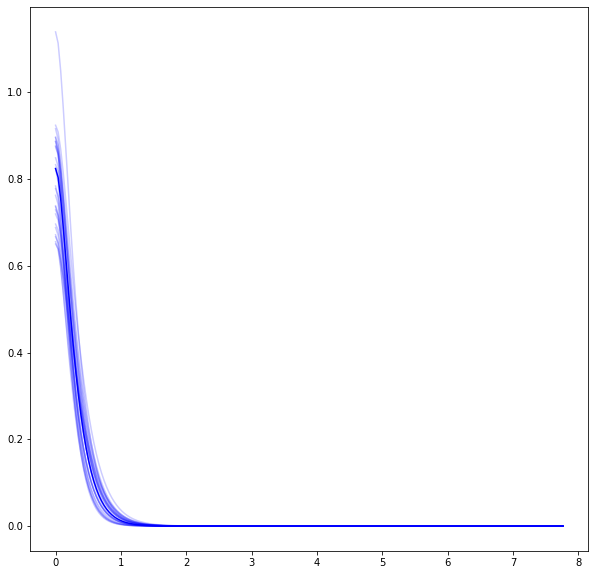

In [457]:
for i in np.arange(0,499,20):
    kern_ = gpflow.kernels.Matern32(lengthscales=gp_samples_dict['kernel_lengthscales'][i],variance=gp_samples_dict['kernel_variance'][i])
    plt.plot(xs_semivariogram_unscaled,kern_(xs_semivariogram)[0],color='b',alpha=0.2)
plt.plot(xs_semivariogram_unscaled,kern_mean(xs_semivariogram)[0],color='b')
